In [1]:
# %matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import os
import sys
sys.path.insert(0, 'functions/')
from h5_tools import *
from fitting_tools import *
from tools import *
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

# plot general settings
mpl.rcParams.update({"axes.grid" : True, "grid.color": "gray", "grid.linestyle":":", "grid.alpha": "0.5", "font.size": 14})
plt.rcParams['legend.title_fontsize'] = 'small'

In [3]:
h5dir = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/'

# Select runs

In [4]:
# c1 temps 250-210 K full beam
runnames = ['ferritin_conc_gly_50_6']
datasetnumbers = [2,3,4,5,6]

if len(runnames) == 1:
    runnames = runnames*len(datasetnumbers)
runnames


['ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6']

In [5]:
T, Tr = [], []

for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'

    if os.path.isfile(filename):
        print(filename, "\nFile exists: ", os.path.isfile(filename), "\n")
        info = elog_selected_entries_dict(filename)
        
        for key in info.keys():
            print("{0:20} {1}".format(key, info[key]))
        Tr.append(info['transmission (%)'])
        T.append(float(info['Temperature, K']))
    
    else:
        print(filename, "\nFile exists: False")
T = np.array(T)

/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0002.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_6_0002
Temperature, K       250.0
transmission (%)     100
Absorbers 80um       0.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 250K, full beam
Exposure time (s)    0.0002
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0003.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_6_0003
Temperature, K       240.0
transmission (%)     100
Absorbers 80um       0.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 240K, full beam
Exposure time (s)    0.0002
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0004.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_6_0004
Temp

In [6]:
beta_vs_q = np.load('../03-source/contrast_vs_q.npy')

In [7]:
filename = h5dir + f'{runname}_{datasetnumbers[0]:04d}.h5'
delay = load_data(filename, 'xpcs/g2s/delay')
qv = load_data(filename, 'xpcs/g2s/q')

rep = 0
g2s = np.empty(shape=(len(datasetnumbers),len(qv),len(delay)))
dg2s = np.empty(shape=(len(datasetnumbers),len(qv),len(delay)))
delays = np.empty(shape=(len(datasetnumbers), len(delay)))

for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
    g2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_filtered')[rep,:,:]
    dg2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_err')[rep,:,:]
    delays[i,:] = load_data(filename, 'xpcs/g2s/delay')
    
print("Shape of the g2s (temp, qs, delay): ", np.shape(g2s))

Shape of the g2s (temp, qs, delay):  (5, 12, 80)


q=0.11 nm$^{-1}$ ferritin_conc_gly_50_6, Transm 100%


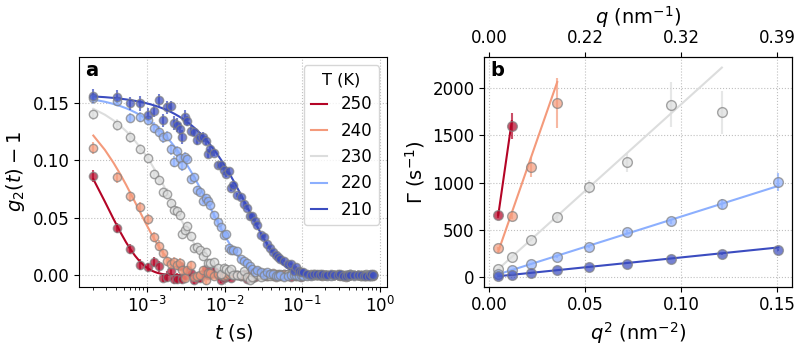

In [8]:
f, (a1,a3) = plt.subplots(1,2, figsize=(8,3.5), constrained_layout=True)
ax2 = a3.twiny()

col = plt.cm.coolwarm_r(np.linspace(0,1,len(datasetnumbers)))
qv_sel = 2
tol = 1e-3
qv_min, qv_max, qstep = 1, len(qv)-2, 1

for i in range(len(datasetnumbers)):
    taus, dtaus = [], []
    
    for q in range(qv_min, qv_max, qstep):
        base = np.average(g2s[i,q,-15:])
        popt,xc,curve,perr = fit(exponential, delays[i,:], g2s[i,q,:]-base, sigma=dg2s[i,q,:], p0=[beta_vs_q[i],5e-2], bounds=[(beta_vs_q[i]-tol,0),(beta_vs_q[i]+tol,np.infty)])
        taus.append(popt[1])
        dtaus.append(perr[1])
        
        if q==qv_sel:
            # a1.errorbar(delays[i,:], g2s[i,q,:]-base, dg2s[i,q,:], c=col[i], ls='', marker='o', ms=5, mfc='none', alpha=0.7)
            a1.errorbar(delays[i,:], g2s[i,q,:]-base, dg2s[i,q,:], c=col[i], ls='', marker='o', ms=6, mec='gray', alpha=0.7)
            a1.plot(xc, curve, c=col[i], ls='-', alpha=1, label=f'{T[i]:.0f}')
    
    qs = qv[qv_min:qv_max:qstep]
    taus, dtaus = np.asarray(taus), np.asarray(dtaus)
    cond = (taus>dtaus) & (dtaus!=0) & (taus>delays[0,1])

    popt,xc,curve,perr = fit(linear, qs[cond]**2, 1/taus[cond], sigma=dtaus[cond]/(taus[cond]**2), p0=[5e3])

    a3.plot(xc, curve, c=col[i])
    # a3.errorbar(qs[cond]**2, 1/taus[cond], dtaus[cond]/(taus[cond]**2), c=col[i], ls='', marker='o', mfc='none')
    a3.errorbar(qs[cond]**2, 1/taus[cond], dtaus[cond]/(taus[cond]**2), c=col[i], ls='', marker='o', mec='gray', alpha=0.7, ms=7)

a1.legend(title=r'T (K)', fontsize=12, bbox_to_anchor=[1,1], handlelength=1, frameon=True)
print(f"q={qv[qv_sel]:.2f} nm$^{{-1}}$", f"{runname}, Transm {Tr[i]}%")
a1.set_xscale('log')
a1.set_xlabel(r'$t$ (s)')
a1.set_ylabel(r'$g_2(t)-1$')
a1.set_yticks(np.arange(0,0.16,0.05))
a1.set_ylim(-0.01,0.19)
a1.tick_params(axis='both', which='minor')#, bottom=False)
a1.tick_params(axis='both', which='major', labelsize=12)
a1.tick_params(axis='both', which='minor', labelsize=10)

a3.set_xlabel(r'$q^2$ (nm$^{-2}$)')
a3.set_ylabel(r'$\Gamma$ (s$^{-1}$)')
# a3.set_xscale('log')
# a3.set_yscale('log')
a3.set_xticks(np.arange(0,0.16,0.05))
a3.tick_params(axis='both', which='minor')#, bottom=False)
a3.tick_params(axis='both', which='major', labelsize=12)
a3.tick_params(axis='both', which='minor', labelsize=10)
a1.text(0.02, 0.92, 'a', fontweight='bold', transform=a1.transAxes)
a3.text(0.02, 0.92, 'b', fontweight='bold', transform=a3.transAxes)

# top axis
ax2.set_xlim(a3.get_xlim())
ax2.set_xticks(np.arange(0,0.16,0.05))
ax2.set_xticklabels([f"{x:.2f}" for x in np.sqrt(np.arange(0,0.16,0.05))])
ax2.set_xlabel('$q$ (nm$^{-1}$)')
ax2.grid(False)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='minor', labelsize=10)

**Viscosities for SE**

In [9]:
etas = viscosity()
etas

,temp,50w%,50v%,60v%,c1,c2,c3
0,300,0.004674,0.006357,0.011691,0.006726,0.008012,0.010947
1,290,0.006771,0.009497,0.018606,0.010106,0.012256,0.017301
2,280,0.010448,0.015197,0.032089,0.016282,0.020171,0.029595
3,270,0.017490,0.026578,0.061359,0.028708,0.036484,0.056042
4,260,0.032565,0.052163,0.134000,0.056900,0.074554,0.120980
5,250,0.069890,0.119340,0.348570,0.131720,0.179070,0.310370
6,240,0.182690,0.337190,1.149900,0.377570,0.536700,1.007000
7,230,0.635210,1.289300,5.300200,1.469200,2.204400,4.550300
8,220,3.416900,7.785200,40.015000,9.060500,14.508000,33.555000
9,210,37.846000,98.826000,657.370000,117.890000,203.600000,536.700000


In [10]:
SE2 = pd.DataFrame(columns=['temperature', 'D_50', 'D_60'])
SE = pd.DataFrame(columns=['temperature', 'D_c1', 'D_c2', 'D_c3'])

for temp in etas['temp']:
    # default uses Rh=6.6e-9 m
    row2 = {'temperature': temp,  'D_50': D_coeff(T=temp, eta=etas[etas['temp']==temp]['50v%'].values[0]), "D_60": D_coeff(T=temp, eta=etas[etas['temp']==temp]['60v%'].values[0]), "D_50w": D_coeff(T=temp, eta=etas[etas['temp']==temp]['50w%'].values[0])}
    SE2 = SE2.append(row2, ignore_index=True)
    
    row = {'temperature': temp,  'D_c1': D_coeff(T=temp, eta=etas[etas['temp']==temp]['c1'].values[0]), "D_c2": D_coeff(T=temp, eta=etas[etas['temp']==temp]['c2'].values[0]), "D_c3": D_coeff(T=temp, eta=etas[etas['temp']==temp]['c3'].values[0])}
    SE = SE.append(row, ignore_index=True)
SE

/tmp/ipykernel_14933/944876902.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SE2 = SE2.append(row2, ignore_index=True)
/tmp/ipykernel_14933/944876902.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SE = SE.append(row, ignore_index=True)
/tmp/ipykernel_14933/944876902.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SE2 = SE2.append(row2, ignore_index=True)
/tmp/ipykernel_14933/944876902.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SE = SE.append(row, ignore_index=True)
/tmp/ipykernel_14933/944876902.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use p

,temperature,D_c1,D_c2,D_c3
0,300.0,4.475183e-12,3.756986e-12,2.749701e-12
1,290.0,2.879241e-12,2.374152e-12,1.681845e-12
2,280.0,1.725479e-12,1.392804e-12,9.492902e-13
3,270.0,9.436700e-13,7.425413e-13,4.834031e-13
4,260.0,4.584800e-13,3.499143e-13,2.156349e-13
5,250.0,1.904354e-13,1.400801e-13,8.082014e-14
6,240.0,6.377832e-14,4.486823e-14,2.391339e-14
7,230.0,1.570747e-14,1.046880e-14,5.071625e-15
8,220.0,2.436295e-15,1.521509e-15,6.578468e-16
9,210.0,1.787317e-16,1.034906e-16,3.925970e-17


0 250.0 0.11
1 240.0 0.11
2 230.0 0.11
3 220.0 0.11
4 210.0 0.11


/tmp/ipykernel_14933/68444909.py:22: RuntimeWarning: invalid value encountered in log
  msd = -3*np.log((g2s[i,q,:]-base) / popt[0]) / qv[q]**2


q=0.11 nm$^{-1}$ ferritin_conc_gly_50_6, Transm 100%


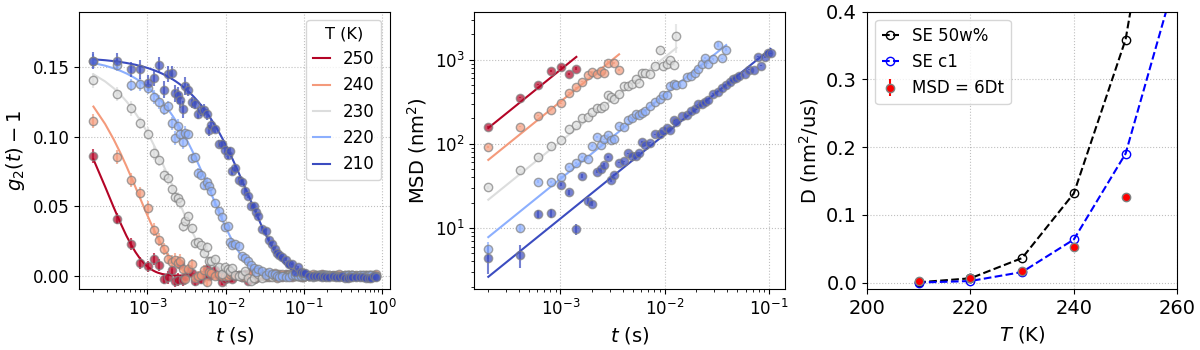

In [13]:
f, (a1,a3,a4) = plt.subplots(1,3, figsize=(12,3.5), constrained_layout=True)

col = plt.cm.coolwarm_r(np.linspace(0,1,len(datasetnumbers)))
qv_sel = 2
tol = 1e-3
qv_min, qv_max, qstep = 1, len(qv)-2, 1
t_lim = 7e2

D_msd = np.empty(shape=(len(datasetnumbers),2))

for i in range(len(datasetnumbers)):
    
    for q in range(qv_min, qv_max, qstep):
        base = np.average(g2s[i,q,-30:])
        popt,xc,curve,perr = fit(exponential, delays[i,:], g2s[i,q,:]-base, sigma=dg2s[i,q,:], p0=[beta_vs_q[i],5e-2], bounds=[(beta_vs_q[i]-tol,0),(beta_vs_q[i]+tol,np.infty)])

        if q==qv_sel:
            a1.errorbar(delays[i,:], g2s[i,q,:]-base, dg2s[i,q,:], c=col[i], ls='', marker='o', ms=6, mec='gray', alpha=0.7)
            a1.plot(xc, curve, c=col[i], ls='-', alpha=1, label=f'{T[i]:.0f}')
            print(i, T[i], f'{qv[q]:.2f}')
            
            msd = -3*np.log((g2s[i,q,:]-base) / popt[0]) / qv[q]**2
            dmsd = 3*dg2s[i,q,:] / abs((g2s[i,q,:]-base) / popt[0]) / qv[q]**2
            
            # -- clean
            mask = ~np.isnan(msd) & ~np.isnan(dmsd)
            mask &= ~np.isinf(msd) & ~np.isinf(dmsd)
            mask &= msd > dmsd

            delays_cleaned = delays[i,mask]
            msd_cleaned = msd[mask]
            dmsd_cleaned = dmsd[mask]
            # -- end cleaning
            
            condition = delays_cleaned < popt[1]*3

            # a3.errorbar(delays_cleaned, msd_cleaned, dmsd_cleaned, c=col[i], ls='', marker='o', ms=6, mec='gray', alpha=0.7, label=f'{T[i]:.0f}')
            a3.errorbar(delays_cleaned[condition], msd_cleaned[condition], dmsd_cleaned[condition], c=col[i], ls='', marker='o', ms=6, mec='gray', alpha=0.7, label=f'{T[i]:.0f}')

            popt,xc,curve,perr = fit(linear, x=delays_cleaned[condition], y=msd_cleaned[condition], sigma=dmsd_cleaned[condition])
            a3.plot(xc, curve, ls='-', c=col[i])
            # a3.axvline(x=xfit[-1], c=col[i], ls=':')

            D_msd[i,0] = popt[0]*1e-6/6
            D_msd[i,1] = perr[0]*1e-6/6

a4.errorbar(T, D_msd[:,0], D_msd[i,1], ls='', c='r', marker='o', mec='gray', label='MSD = 6Dt')
a4.plot(SE['temperature'], SE2['D_50w']*1e12, label='SE 50w%', c='k', marker='o', mec='k', mfc='none', ls='--')
a4.plot(SE['temperature'], SE['D_c1']*1e12, label='SE c1', c='b', marker='o', mec='b', mfc='none', ls='--')

a1.legend(title=r'T (K)', fontsize=12, bbox_to_anchor=[1,1], handlelength=1, frameon=True)
print(f"q={qv[qv_sel]:.2f} nm$^{{-1}}$", f"{runname}, Transm {Tr[i]}%")
a1.set_xscale('log')
a1.set_xlabel(r'$t$ (s)')
a1.set_ylabel(r'$g_2(t)-1$')
a1.set_yticks(np.arange(0,0.16,0.05))
a1.set_ylim(-0.01,0.19)
a1.tick_params(axis='both', which='minor')#, bottom=False)
a1.tick_params(axis='both', which='major', labelsize=12)
a1.tick_params(axis='both', which='minor', labelsize=10)

a3.set_xlabel(r'$t$ (s)')
a3.set_ylabel(r'MSD (nm$^{2}$)')
# a3.set_ylim(0,1e3)
# a3.set_xlim(0,delays[-1,msd<1e3][-1])
a3.set_xscale('log')
a3.set_yscale('log')
a3.tick_params(axis='both', which='minor')#, bottom=False)
a3.tick_params(axis='both', which='major', labelsize=12)
a3.tick_params(axis='both', which='minor', labelsize=10)

a4.set_xlabel(r'$T$ (K)')
a4.set_ylabel(r'D (nm$^2$/us)')
a4.set_xlim(200,260)
a4.set_ylim(-0.01,0.4)
a4.legend(fontsize=12, handlelength=1, frameon=True)
# a4.set_yscale('log')
f.savefig(f'../06-figs/msd-q-{qv[qv_sel]:.2f}-2.png')

### q-dependence for all temperatures

/tmp/ipykernel_14933/1975995873.py:22: RuntimeWarning: invalid value encountered in log
  msd = -3*np.log((g2s[i,q,:]-base) / popt[0]) / qv[q]**2


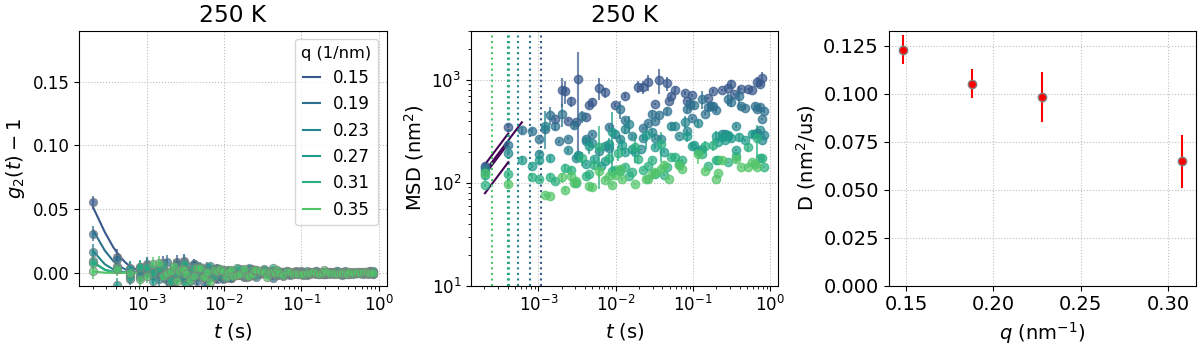

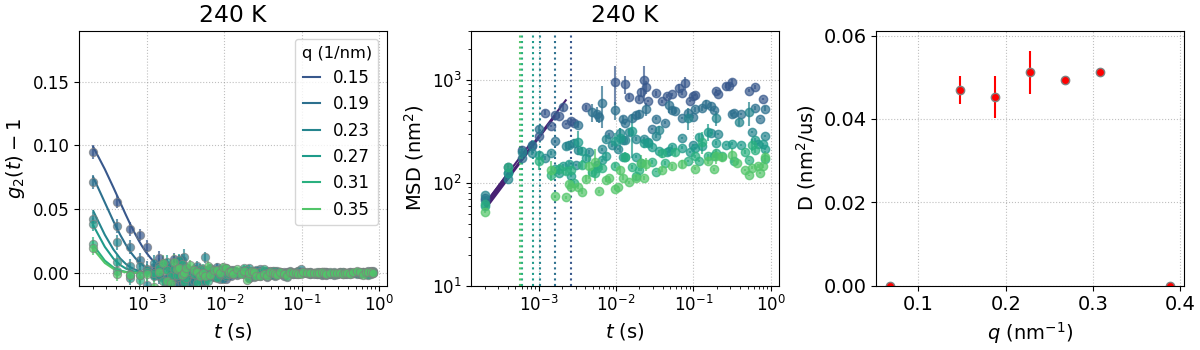

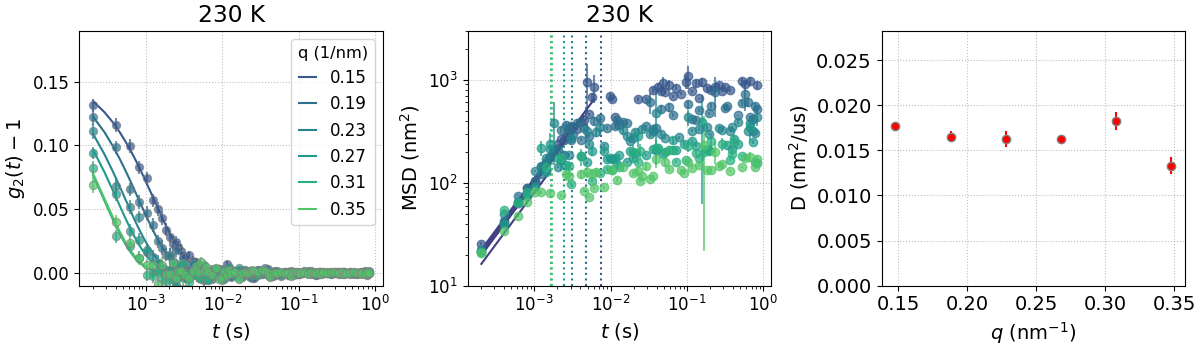

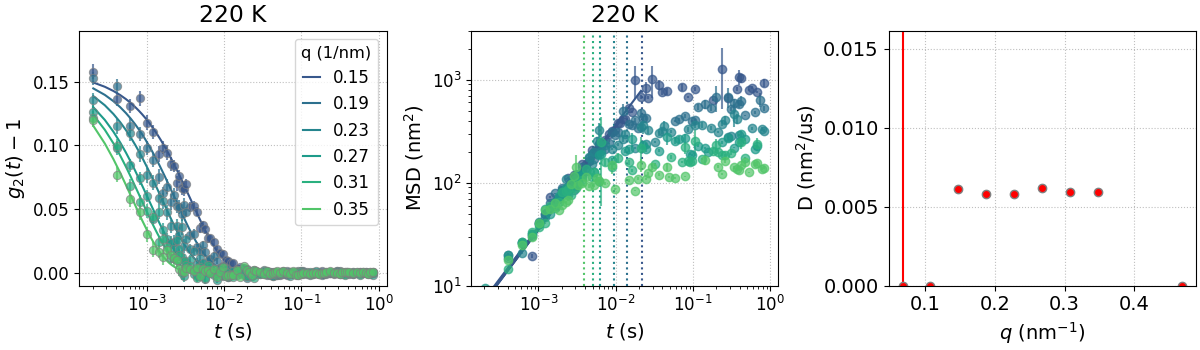

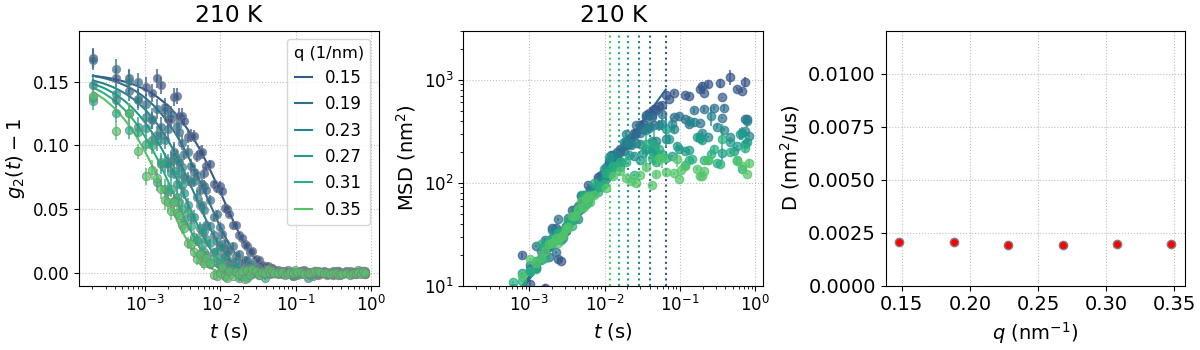

In [14]:
col1 = plt.cm.coolwarm_r(np.linspace(0,1,len(datasetnumbers)))
col = plt.cm.viridis(np.linspace(0,1,len(qv)))

qv_sel = 2
tol = 1e-3
qv_min, qv_max, qstep = 3, len(qv)-3, 1

for i in range(len(datasetnumbers)):
    f, (a1,a3, a4) = plt.subplots(1,3, figsize=(12,3.5), constrained_layout=True)
    
    # qs = np.arange(qv_min, qv_max)
    D_msd = np.empty(shape=(len(qv),2))

    for q in range(qv_min, qv_max, qstep):
        base = np.average(g2s[i,q,-30:])
        popt,xc,curve,perr = fit(exponential, delays[i,:], g2s[i,q,:]-base, sigma=dg2s[i,q,:], p0=[beta_vs_q[i],5e-2], bounds=[(beta_vs_q[i]-tol,0),(beta_vs_q[i]+tol,np.infty)])

        a1.errorbar(delays[i,:], g2s[i,q,:]-base, dg2s[i,q,:], c=col[q], ls='', marker='o', ms=6, mec='gray', mew=.7, alpha=0.7)
        a1.plot(xc, curve, c=col[q], ls='-', alpha=1, label=f'{qv[q]:.2f}')
        
        # -- mean squared displacement
        msd = -3*np.log((g2s[i,q,:]-base) / popt[0]) / qv[q]**2
        dmsd = 3*dg2s[i,q,:] / abs((g2s[i,q,:]-base) / popt[0]) / qv[q]**2
        
        # -- clean
        mask = ~np.isnan(msd) & ~np.isnan(dmsd)
        mask &= ~np.isinf(msd) & ~np.isinf(dmsd)
        mask &= msd > dmsd

        delays_cleaned = delays[i,mask]
        msd_cleaned = msd[mask]
        dmsd_cleaned = dmsd[mask]
        # -- end cleaning
        
        condition = delays_cleaned < popt[1]*3
        xfit = delays_cleaned[condition]
        yfit = msd_cleaned[condition]
        dyfit = dmsd_cleaned[condition]

        # a3.plot(delays[i,:], msd, c=col[q], ls='', marker='o', ms=6, alpha=0.7, label=f'{qv[q]:.2f}') #
        a3.errorbar(delays_cleaned, msd_cleaned, dmsd_cleaned, c=col[q], ls='', marker='o', ms=6, alpha=0.7, label=f'{qv[q]:.2f}')
        a3.axvline(x=popt[1]*3, c=col[q], ls=':' )
        # a1.axvline(x=popt[1]*3, c=col[q], ls=':' )
        try:
            popt,xc,curve,perr = fit(linear, x=xfit, y=yfit, sigma=dyfit)
            a3.plot(xc, curve, ls='-', c=col[i])

            D_msd[q,0] = popt[0]*1e-6/6
            D_msd[q,1] = perr[0]*1e-6/6

        except ValueError:
            pass
    
    cond = (D_msd[:,0] > D_msd[:,1]) & (D_msd[:,0] < 50)
    a4.errorbar(qv[cond], D_msd[cond,0], D_msd[cond,1], ls='', c='r', marker='o', mec='gray', label='MSD = 6Dt')
    
    a1.legend(title=r'q (1/nm)', fontsize=12, bbox_to_anchor=[1,1], handlelength=1, frameon=True)
    a1.set_title(f'{T[i]:.0f} K')
    a1.set_xscale('log')
    a1.set_xlabel(r'$t$ (s)')
    a1.set_ylabel(r'$g_2(t)-1$')
    a1.set_yticks(np.arange(0,0.16,0.05))
    a1.set_ylim(-0.01,0.19)
    a1.tick_params(axis='both', which='minor')#, bottom=False)
    a1.tick_params(axis='both', which='major', labelsize=12)
    a1.tick_params(axis='both', which='minor', labelsize=10)

    a3.set_xlabel(r'$t$ (s)')
    a3.set_ylabel(r'MSD (nm$^{2}$)')
    a3.set_title(f'{T[i]:.0f} K')
    a3.set_ylim(10,3e3)
    # a3.set_xlim(0,0.04)
    a3.set_xscale('log')
    a3.set_yscale('log')
    a3.tick_params(axis='both', which='minor')#, bottom=False)
    a3.tick_params(axis='both', which='major', labelsize=12)
    a3.tick_params(axis='both', which='minor', labelsize=10)

    a4.set_xlabel(r'$q$ (nm$^{-1}$)')
    a4.set_ylabel(r'D (nm$^2$/us)')
    a4.set_ylim(0,np.max(D_msd[cond,0])+0.01)
    f.savefig(f'../06-figs/msd-{T[i]:.0f}K.png')
